In [122]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, AgglomerativeClustering, OPTICS
from sklearn.model_selection import ParameterSampler
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

data = './data/'
pd.set_option("display.max_columns", None)

# Clustering
Often, we think of data in terms of groups, e.g., "People with a smoking habit and over 60 are more likely to die of Covid."
Sometimes these groups are given, and we can assign each record to a group.
But more often, the question itself is: which are the groups?

**Clustering objective**

Grouping a set of instances such that the instances in the same cluster are more ***similar*** (in some sense) to each other than to those in other clusters.  
The result of a clustering algorithm is a ***clustering***, that is a set of clusters.
Clustering is an ***unsupervised*** task, i.e., the real cluster partitioning is unknown.  

In [6]:
df = pd.read_csv(f'{data}correct_tips.csv', index_col=0)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 244 entries, 1 to 244
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
 7   age         244 non-null    int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 17.2+ KB


In [8]:
num_col = ['total_bill', 'tip', 'size', 'age']
cat_col = ['sex','smoker','day', 'time']

df_cat = df[cat_col]
df = df.drop(columns=cat_col)

In [11]:
df.head()

,total_bill,tip,size,age
ID,,,,
1,16.99,3.006461,2,57
2,10.34,1.660000,3,23
3,21.01,3.500000,3,62
4,23.68,3.310000,2,62
5,24.59,3.610000,4,62


## Preprocessing

## Data engineering

In [12]:
 #new column created - percent of tip
df["tip_ratio"] = df["tip"]/df["total_bill"] 

# new column created - sum of total bill and tip
df["sum"] = df["total_bill"]+df["tip"] # appended at the end of the array

# new column created - ratio of tip to sum
df["percent"] = round(df["tip"]/df["sum"]*100, 2)

# add column: bpp - bill per person
df["bpp"] = df["total_bill"]/df["size"]

# add column: tpp - tip per person
df["tpp"] = df["tip"]/df["size"]
df.head()

,total_bill,tip,size,age,tip_ratio,sum,percent,bpp,tpp
ID,,,,,,,,,
1,16.99,3.006461,2,57,0.176955,19.996461,15.03,8.495000,1.503230
2,10.34,1.660000,3,23,0.160542,12.000000,13.83,3.446667,0.553333
3,21.01,3.500000,3,62,0.166587,24.510000,14.28,7.003333,1.166667
4,23.68,3.310000,2,62,0.139780,26.990000,12.26,11.840000,1.655000
5,24.59,3.610000,4,62,0.146808,28.200000,12.80,6.147500,0.902500


In [13]:
df

,total_bill,tip,size,age,tip_ratio,sum,percent,bpp,tpp
ID,,,,,,,,,
1,16.99,3.006461,2,57,0.176955,19.996461,15.03,8.495000,1.503230
2,10.34,1.660000,3,23,0.160542,12.000000,13.83,3.446667,0.553333
3,21.01,3.500000,3,62,0.166587,24.510000,14.28,7.003333,1.166667
4,23.68,3.310000,2,62,0.139780,26.990000,12.26,11.840000,1.655000
5,24.59,3.610000,4,62,0.146808,28.200000,12.80,6.147500,0.902500
...,...,...,...,...,...,...,...,...,...
240,29.03,5.920000,3,25,0.203927,34.950000,16.94,9.676667,1.973333
241,27.18,2.000000,2,42,0.073584,29.180000,6.85,13.590000,1.000000
242,22.67,2.000000,2,64,0.088222,24.670000,8.11,11.335000,1.000000


### Normalization
A good practice in clustering to avoid the bias given by the range of the different attribute is normalization.  
The most common adopted normalizations are: Z-Score and Min-Max

In [14]:
# since several algorithms are randomized, we set a seed to repeat them
RANDOM_STATE = 42

In [16]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler()
X = scaler.fit_transform(df.values)

In [17]:
pd.DataFrame(scaler.inverse_transform(scaler.transform(df)), columns=df.columns)

/Users/lorenzomannocci/anaconda3/envs/phd/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


,total_bill,tip,size,age,tip_ratio,sum,percent,bpp,tpp
0,16.99,3.006461,2.0,57.0,0.176955,19.996461,15.03,8.495000,1.503230
1,10.34,1.660000,3.0,23.0,0.160542,12.000000,13.83,3.446667,0.553333
2,21.01,3.500000,3.0,62.0,0.166587,24.510000,14.28,7.003333,1.166667
3,23.68,3.310000,2.0,62.0,0.139780,26.990000,12.26,11.840000,1.655000
4,24.59,3.610000,4.0,62.0,0.146808,28.200000,12.80,6.147500,0.902500
...,...,...,...,...,...,...,...,...,...
239,29.03,5.920000,3.0,25.0,0.203927,34.950000,16.94,9.676667,1.973333
240,27.18,2.000000,2.0,42.0,0.073584,29.180000,6.85,13.590000,1.000000
241,22.67,2.000000,2.0,64.0,0.088222,24.670000,8.11,11.335000,1.000000
242,17.82,1.750000,2.0,72.0,0.098204,19.570000,8.94,8.910000,0.875000


# K-Means

#### The Algorithm in a Nutshell

**Objective:** Clusters the data into $k$ groups.
* **Init step:** Select k points at random as cluster centers.
* **Assignment step:** Assign each instance to the cluster with the closest mean according to the distance function.
* **Update step**: Calculate the new means to be the centroids of the instances in the new clusters.
* ***Repeat*** steps 2 and 3 until the assignment no longer change.

There is no guarantee that the optimum is found using this algorithm.

> Tan, P. N. (2006). Introduction to data mining. Pearson Education India.

Running [example](http://matlaspisa.isti.cnr.it:5055/K-Means)
Wikipedia [link](https://en.wikipedia.org/wiki/K-means_clustering)

#### K-Means Problems

* Initial Centroids
* Number of clusters

In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Parameters:
* **n_clusters** (default 8): The number of clusters
* **n_init** (default 10): Number of time k-means will be run with different initial centroids. The final results will be the best output in terms of inertia.
* **max_iter** (default 300): Maximum number of iterations of the k-means algorithm for a single run.

In [19]:
kmeans = KMeans(n_clusters=3, n_init=10, max_iter=100)
kmeans.fit(X)

KMeans(max_iter=100, n_clusters=3, n_init=10)

Output:
* **labels_**: Labels of each point
* **cluster\_centers_**: Coordinates of cluster centers
* **inertia_**: Sum of squared distances of samples to their closest cluster center.

Labels

In [20]:
kmeans.labels_[:5]

array([1, 2, 1, 1, 1], dtype=int32)

Observing the size of each cluster

In [21]:
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2], dtype=int32), array([ 41, 105,  98]))

Visualization of the clustering in two dimensions.

<Axes: xlabel='total_bill', ylabel='tip'>

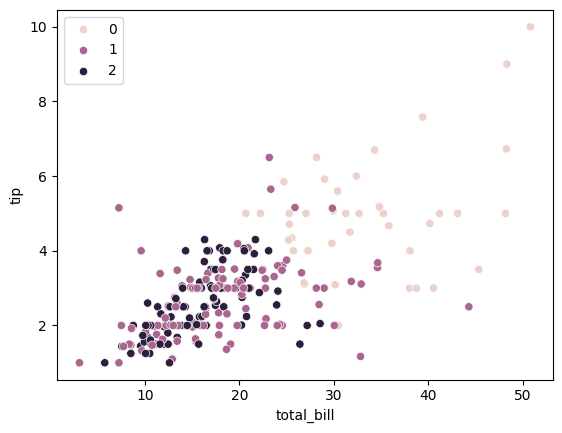

In [22]:
sns.scatterplot(data=df, x="total_bill", y="tip", hue=kmeans.labels_)

Centers

In [23]:
kmeans.cluster_centers_

array([[0.63780437, 0.4403523 , 0.53658537, 0.27537372, 0.17373885,
        0.60648486, 0.25416056, 0.40559597, 0.37070399],
       [0.31979572, 0.18783752, 0.28190476, 0.80890937, 0.18585366,
        0.29886474, 0.26538149, 0.28781199, 0.26676536],
       [0.26231586, 0.16959184, 0.25510204, 0.20457538, 0.19184217,
        0.24760814, 0.2788053 , 0.23929353, 0.25242927]])

In [24]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)

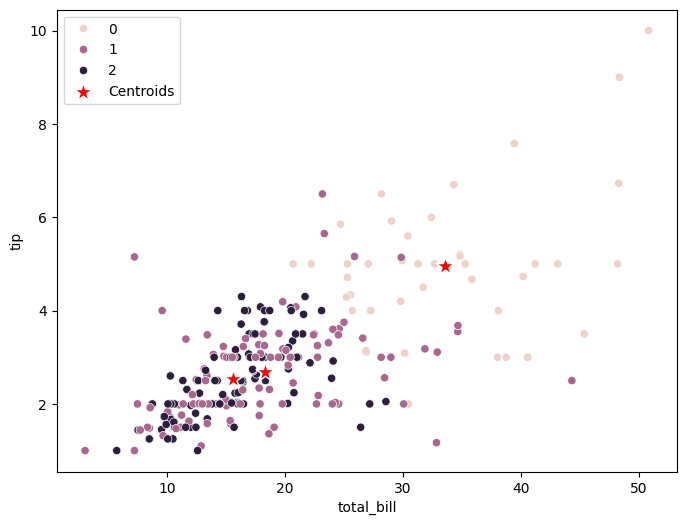

In [25]:
# Create a single plot
plt.figure(figsize=(8, 6))

# Second scatter plot: for the numeric_dataset with KMeans labels
sns.scatterplot(data=df, x="total_bill", y="tip", hue=kmeans.labels_)

# Plot the NumPy data with a different marker style
sns.scatterplot(x=centers[:,0], y=centers[:, 1], label='Centroids', s=200, marker='*', c='r')


# Add labels and title
plt.xlabel('total_bill')
plt.ylabel('tip')

# Display the plot
plt.legend()
plt.show()

Visualization of clusters centers by means of parallel coordinates

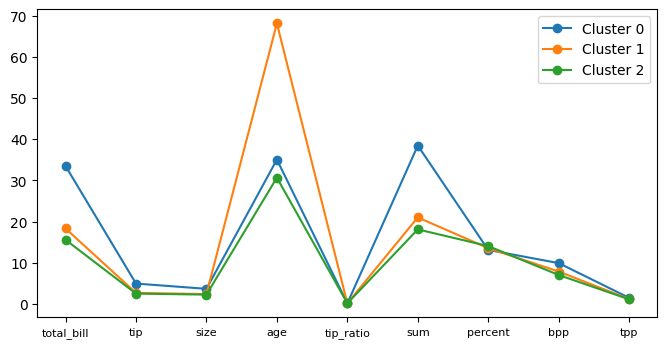

In [26]:
plt.figure(figsize=(8, 4))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(range(0, len(df.columns)), df.columns, fontsize=8)
plt.legend(fontsize=10)
plt.show()

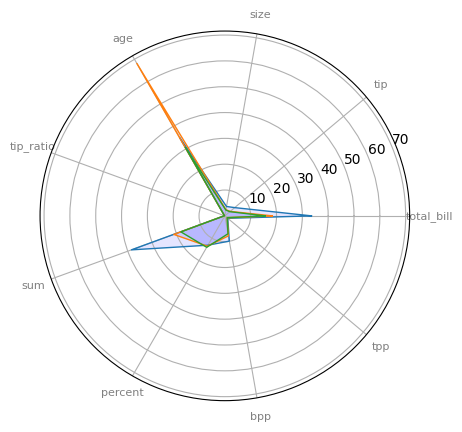

In [27]:
from math import pi
 
# number of variable
N = len(df.columns)
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
for i in range(0, len(centers)):
    angles = [n / float(N) * 2 * pi for n in range(N)]
    values = centers[i].tolist()
    values += values[:1]
    angles += angles[:1]
# Initialise the spider plot
    ax = plt.subplot(polar=True)
# Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], df.columns, color='grey', size=8) 
# Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')
 # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)

# Metrics to Evaluate Clustering

When performing clustering, it is important to **evaluate the quality of the clusters**.  
Here are three commonly used metrics:

---

## 1. Silhouette Score

- Measures how **similar an object is to its own cluster** compared to other clusters.  
- Value ranges from **-1 to 1**:
  - **+1** → the object is well-matched to its own cluster and far from other clusters  
  - **0** → the object is on or very close to the decision boundary between clusters  
  - **-1** → the object is likely assigned to the wrong cluster

**Formula** (for a single sample):
$$
s = \frac{b - a}{\max(a, b)}
$$
- $a$ = average distance to other points in the same cluster  
- $b$ = average distance to points in the nearest cluster  

**Interpretation:** Higher Silhouette → better-defined clusters.

---

## 2. Inertia (Sum of Squared Errors, SSE)

- Measures the **compactness of the clusters**.  
- Calculated as the **sum of squared distances between each point and its cluster center**:

$$
\text{Inertia} = \sum_{i=1}^{n} \| x_i - \mu_{c_i} \|^2
$$
- $x_i$ = data point  
- $\mu_{c_i}$ = centroid of the cluster $c_i$ containing $x_i$

**Interpretation:**  
- Lower inertia → points are closer to cluster centers → more compact clusters.  
- Sensitive to the number of clusters (increases with more clusters, so usually used for **elbow method**).

---

## 3. Separation (Davies-Bouldin Score)

- Measures the **average similarity between each cluster and its most similar cluster**.  
- Combines **cluster dispersion** and **distance between clusters**:

$$
DB = \frac{1}{k} \sum_{i=1}^{k} \max_{j \neq i} \left( \frac{\sigma_i + \sigma_j}{d(c_i, c_j)} \right)
$$
- $\sigma_i$ = average distance of all points in cluster $i$ to its centroid  
- $d(c_i, c_j)$ = distance between centroids of clusters $i$ and $j$  
- $k$ = number of clusters

**Interpretation:**  
- **Lower DB score → better clusters** (more compact and well-separated).

---

### Summary Table

| Metric                  | What it Measures                   | Optimal Value | Range |
|-------------------------|----------------------------------|---------------|-------|
| Silhouette Score        | Cohesion vs separation           | 1 (higher is better) | [-1, 1] |
| Inertia (SSE)           | Cluster compactness               | 0 (lower is better)  | [0, ∞) |
| Davies-Bouldin Score    | Separation | 0 (lower is better) | [0, ∞) |

In [28]:
from sklearn import metrics

print('SSE %s' % kmeans.inertia_) # cohesion, lower value better clustering (error minimization)
print('Separation %s' % metrics.davies_bouldin_score(X, kmeans.labels_)) # lower value, better clustering (minimum zero)
print('Silhouette %s' % silhouette_score(X, kmeans.labels_))
# Silhouette. The best value is 1 and the worst value is -1. 
# Values near 0 indicate overlapping clusters. 
# Negative values generally indicate that a sample has been assigned to the wrong cluster

SSE 43.17585218788298
Separation 1.1889089309670433
Silhouette 0.2914737980353823


In [29]:
cross_df = pd.crosstab(kmeans.labels_,df_cat['time'])
cross_df

time,Dinner,Lunch
row_0,,
0,32,9
1,72,33
2,72,26


In [30]:
cross_df = pd.crosstab(kmeans.labels_,df_cat['day'])
cross_df

day,Fri,Sat,Sun,Thur
row_0,,,,
0,2,14,16,9
1,7,36,32,30
2,10,37,28,23


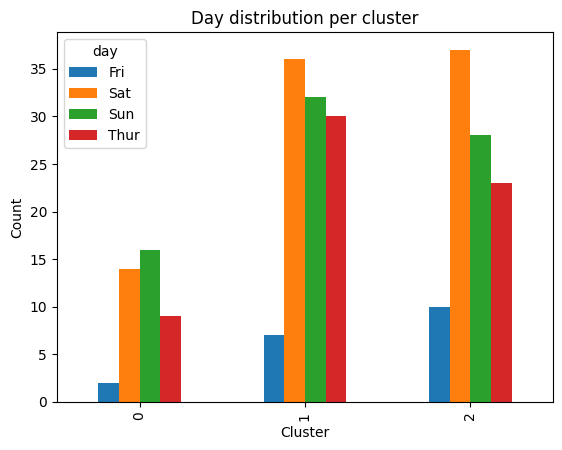

In [31]:
cross_df = pd.crosstab(kmeans.labels_, df_cat['day'])

cross_df.plot(kind='bar', stacked=False, 
                   title='Day distribution per cluster')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

### K parameter estimation
Knee Method to estimate the best K

In [32]:
sse_list = list()
max_k = 40
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X)
    
    sse = kmeans.inertia_
    sse_list.append(sse)

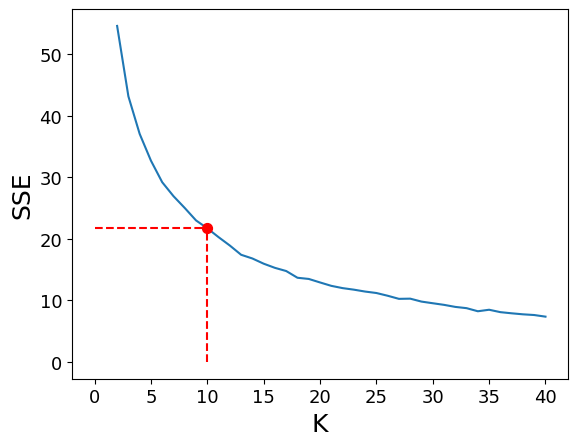

In [33]:
# Point to highlight
k_star = 10
sse_star = sse_list[k_star - 2]  # adjust for zero-index

plt.plot(range(2, len(sse_list) + 2), sse_list)
plt.ylabel('SSE', fontsize=18)
plt.xlabel('K', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=13)

# Vertical line ending at the point
plt.vlines(x=k_star, ymin=0, ymax=sse_star, colors='red', linestyles='dashed')

# Horizontal line ending at the point
plt.hlines(y=sse_star, xmin=0, xmax=k_star, colors='red', linestyles='dashed')

# Highlight the point
plt.scatter(k_star, sse_star, color='red', s=50, zorder=5)

plt.show()

# DBSCAN

### The Algorithm in a Nutshell

* A point is a **core** if it has more than minPts points within eps
* A point is a **border** if it has less than minPts points within eps but one of its neighboors is a core point
* A **noise** point is neither a core or a border point


1. Label all points as core, border or noise points
1. Eliminate noise points.
1. Put an edge between all core points that are within eps of each other
1. Make each group of connected core points into a separate cluster.
1. Assign each border point to one of the clusters of its associated core points.

> Ester, M., Kriegel, H. P., Sander, J., & Xu, X. (1996, August). A density-based algorithm for discovering clusters in large spatial databases with noise. In Kdd (Vol. 96, No. 34, pp. 226-231).

Running [example](http://matlaspisa.isti.cnr.it:5055/Dbscan)  
Wikipedia [link](https://en.wikipedia.org/wiki/DBSCAN)

### DBSCAN Problems

* Parameter tuning
* Does not recognize different densities

In [34]:
from sklearn.cluster import DBSCAN

Parameters:
* **eps**: The maximum distance between two samples for them to be considered as in the same neighborhood.
* **min_samples**: The number of samples in a neighborhood for a point to be considered as a core point. This includes the point itself.

In [77]:
# MinPts = 2·D
# Eps->Elbow Method
dbscan = DBSCAN(eps=0.24, min_samples=3)
dbscan.fit(X)

DBSCAN(eps=0.24, min_samples=3)

* **labels_**: Cluster labels for each point in the dataset. Noisy samples are given the label -1.

In [79]:
np.unique(dbscan.labels_, return_counts=True)

(array([-1,  0,  1]), array([ 47, 148,  49]))

Visualization of the clustering in two dimensions.

<Axes: xlabel='total_bill', ylabel='tip'>

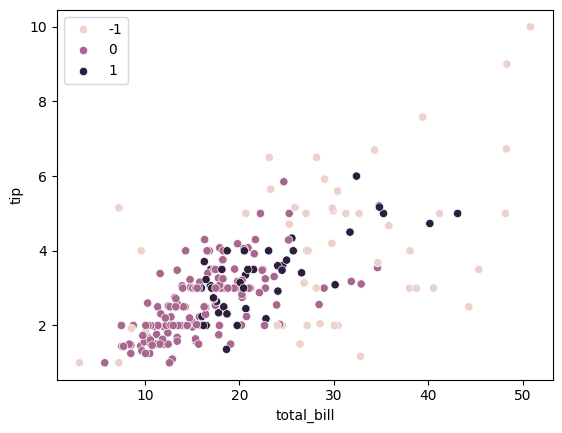

In [84]:
sns.scatterplot(data=df, x="total_bill", y="tip", hue=dbscan.labels_, legend='full')

Clustering Validation

In [85]:
print('Silhouette %s' % silhouette_score(X, dbscan.labels_))

Silhouette 0.10150806727520924


Knee Method to estimate the best eps

In [86]:
from scipy.spatial.distance import pdist, squareform

In [87]:
dist = pdist(X, 'euclidean') #pair wise distance
print (dist.shape)
dist = squareform(dist) #distance matrix given the vector dist
print(dist.shape)

(29646,)
(244, 244)


In [88]:
k = 3
kth_distances = list()
for d in dist:
    # argsort(): it gives you the indices that you would use to reorder the elements in an array to be in sorted order
    index_kth_distance = np.argsort(d)[k] 
    kth_distances.append(d[index_kth_distance])

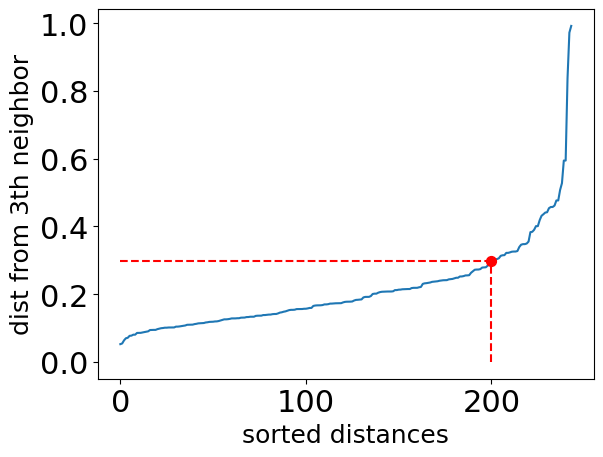

In [97]:
plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
plt.xlabel('sorted distances', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=22)

sorted_distances = sorted(kth_distances)
# Highlight a specific point
highlight_index = 200  # for example, the last point
x_point = highlight_index if highlight_index >= 0 else len(sorted_distances) + highlight_index
y_point = sorted_distances[x_point]

# Vertical line ending at the point
plt.vlines(x=x_point, ymin=0, ymax=y_point, colors='red', linestyles='dashed')

# Horizontal line ending at the point
plt.hlines(y=y_point, xmin=0, xmax=x_point, colors='red', linestyles='dashed')

# Highlight the point
plt.scatter(x_point, y_point, color='red', s=50, zorder=5)


plt.show()

## Hierarchical clustering 

There are 2 kinds of hierarchical clustering: agglomerative and divisive. 

In the following, there are some example of the agglomerative clustering using scipy. The scipy library allows for hierachical clusters by exploiting the linkage function and then the dendrogram. The first function, given a matrix of pair-wise distances, computes the agglomerative clustering. 

There are 2 parameters: the method, that can be single, complete, ward, average, weighted, centroids and median, and the metric used to compute the distances, such as euclidean or cosine. Then, with the dendrogram function, it is possible to visualize the result obtained. This kind of clustering is also possible with scikit-learn library, but the dendrogram visualization is not directly available.

# Hierarchical Clustering

Hierarchical clustering is a type of clustering that produces a **tree-like structure (dendrogram)** representing nested clusters.  
There are **two main kinds**:

1. **Agglomerative (bottom-up)**  
   - Start with each data point as its own cluster.  
   - Iteratively **merge the closest clusters** until all points belong to a single cluster.

2. **Divisive (top-down)**  
   - Start with all points in a single cluster.  
   - Iteratively **split clusters** until each point is in its own cluster.  

> In practice, **agglomerative clustering** is more commonly used.

---

## Agglomerative Clustering with `scipy`

The `scipy` library allows hierarchical clustering using:

1. **`linkage` function**  
   - Input: a matrix of pairwise distances (or raw data).  
   - Computes the hierarchical clustering using a specified method and metric.  
   - **Parameters**:
     - `method` → how to compute distances between clusters:
       - `single` → minimum distance between points in clusters  
       - `complete` → maximum distance  
       - `average` → average distance  
       - `ward` → minimizes variance within clusters  
       - `weighted`, `centroids`, `median` → other variations
     - `metric` → distance measure between points, e.g., `euclidean`, `cosine`, `manhattan`

2. **`dendrogram` function**  
   - Visualizes the hierarchical clustering as a tree.  
   - The **vertical axis** represents the distance at which clusters are merged.  
   - By **cutting the dendrogram** at a given height, you can select the desired number of clusters.

---

## Agglomerative Clustering with `scikit-learn`

- The `sklearn.cluster.AgglomerativeClustering` class also performs agglomerative clustering.  
- Parameters include:
  - `n_clusters` → number of clusters to form  
  - `linkage` → `ward`, `complete`, `average`, or `single`  
  - `affinity` → distance metric (`euclidean` for Ward, other metrics for others)  
- Note: **dendrogram visualization is not directly available** in scikit-learn.  
  - You can compute linkage with `scipy` to plot the dendrogram while using `sklearn` for clustering.

---

### Observations

- Hierarchical clustering **does not require specifying the number of clusters upfront**.  
- Agglomerative clustering is most commonly used and well supported in `scipy` and `scikit-learn`.  
- Use **linkage methods** and **distance metrics** to control how clusters are merged.  
- **Dendrograms** are useful to visualize cluster structure and determine an appropriate number of clusters.


In [98]:
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

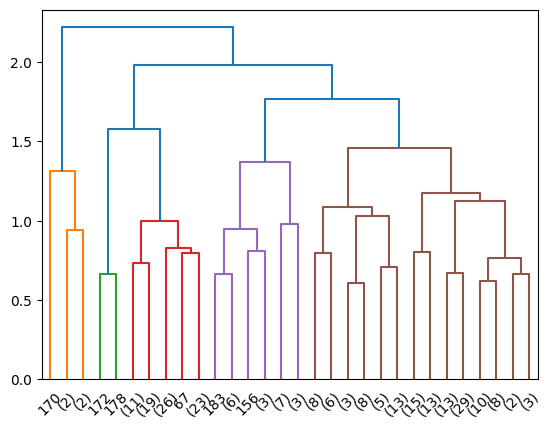

In [100]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='complete', metric='euclidean')
res = dendrogram(data_link, color_threshold=1.5, truncate_mode='lastp')

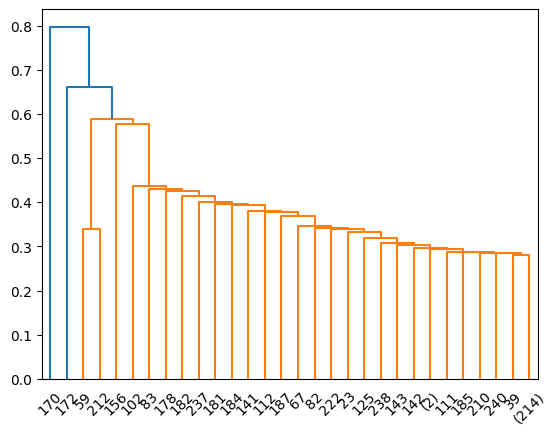

In [113]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='single', metric='euclidean')
res = dendrogram(data_link, color_threshold=0.6, truncate_mode='lastp')

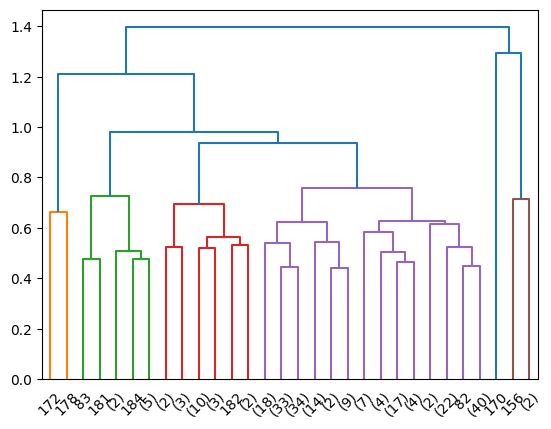

In [115]:
data_dist = pdist(X, metric='euclidean')
data_link = linkage(data_dist, method='average', metric='euclidean')
res = dendrogram(data_link, color_threshold=0.8, truncate_mode='lastp')

In [116]:
#with sciki-learn you have to select the number of clusters you want
from sklearn.cluster import AgglomerativeClustering

agg_cluster = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
agg_cluster.fit_predict(X)


array([3, 0, 3, 3, 1, 0, 0, 1, 3, 3, 0, 2, 3, 1, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 3, 1, 0, 0, 0, 3, 0, 0, 3, 1, 3, 3, 1, 0, 1, 2, 0, 0, 3, 0,
       1, 3, 0, 2, 0, 0, 0, 3, 2, 0, 0, 3, 2, 0, 3, 1, 3, 0, 3, 0, 0, 3,
       3, 3, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 3, 3, 3, 3, 3, 1, 3, 2, 0, 0,
       0, 3, 1, 3, 0, 0, 3, 2, 0, 0, 0, 0, 0, 3, 1, 3, 3, 3, 0, 0, 0, 0,
       3, 3, 1, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 3, 3, 2, 3, 0, 3, 1, 3, 3,
       3, 3, 3, 0, 0, 3, 0, 3, 0, 2, 2, 2, 3, 3, 1, 3, 0, 3, 3, 3, 0, 1,
       1, 1, 1, 1, 3, 0, 0, 3, 1, 0, 3, 3, 0, 2, 0, 0, 2, 0, 3, 1, 3, 1,
       3, 0, 3, 1, 1, 1, 1, 1, 1, 2, 0, 1, 3, 0, 0, 3, 1, 3, 3, 0, 0, 2,
       0, 3, 0, 3, 3, 0, 0, 0, 3, 2, 3, 0, 3, 1, 1, 3, 2, 3, 1, 0, 3, 0,
       3, 3, 3, 0, 0, 0, 0, 1, 3, 0, 1, 3, 3, 0, 3, 0, 0, 1, 2, 2, 0, 3,
       3, 3])

In [117]:
agg_cluster.labels_

array([3, 0, 3, 3, 1, 0, 0, 1, 3, 3, 0, 2, 3, 1, 3, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 3, 1, 0, 0, 0, 3, 0, 0, 3, 1, 3, 3, 1, 0, 1, 2, 0, 0, 3, 0,
       1, 3, 0, 2, 0, 0, 0, 3, 2, 0, 0, 3, 2, 0, 3, 1, 3, 0, 3, 0, 0, 3,
       3, 3, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0, 3, 3, 3, 3, 3, 1, 3, 2, 0, 0,
       0, 3, 1, 3, 0, 0, 3, 2, 0, 0, 0, 0, 0, 3, 1, 3, 3, 3, 0, 0, 0, 0,
       3, 3, 1, 0, 0, 3, 1, 0, 0, 0, 0, 0, 0, 3, 3, 2, 3, 0, 3, 1, 3, 3,
       3, 3, 3, 0, 0, 3, 0, 3, 0, 2, 2, 2, 3, 3, 1, 3, 0, 3, 3, 3, 0, 1,
       1, 1, 1, 1, 3, 0, 0, 3, 1, 0, 3, 3, 0, 2, 0, 0, 2, 0, 3, 1, 3, 1,
       3, 0, 3, 1, 1, 1, 1, 1, 1, 2, 0, 1, 3, 0, 0, 3, 1, 3, 3, 0, 0, 2,
       0, 3, 0, 3, 3, 0, 0, 0, 3, 2, 3, 0, 3, 1, 1, 3, 2, 3, 1, 0, 3, 0,
       3, 3, 3, 0, 0, 0, 0, 1, 3, 0, 1, 3, 3, 0, 3, 0, 0, 1, 2, 2, 0, 3,
       3, 3])

<Axes: xlabel='total_bill', ylabel='tip'>

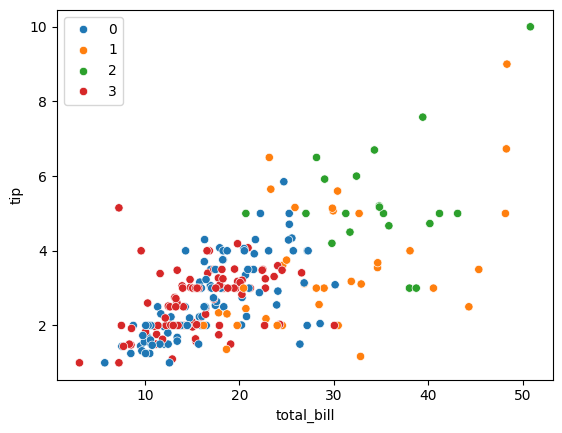

In [120]:
sns.scatterplot(data=df, x="total_bill", y="tip", hue=agg_cluster.labels_, legend='full', palette=sns.color_palette(n_colors=len(np.unique(agg_cluster.labels_))))


## Alternative libraries and Clustering algorithms
Two additional libraries:
- [pyclustering](https://pypi.org/project/pyclustering/)
- [densired](https://github.com/PhilJahn/DENSIRED)

The latter is quite experimental.